In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
delta=0.01
mass=1
omega=1

In [110]:
class WaveFunction(nn.Module):
    def __init__(self):
        super(WaveFunction, self).__init__()

        self.layer1=nn.Linear(1,32)
        self.layer2=nn.Linear(32,32)
        self.layer3=nn.Linear(32,1)

        self.norm = torch.ones(1, requires_grad=False)

    def forward(self, inputs):
        x = inputs
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        x = torch.tanh(x)
        x = self.layer3(x)

        # boundary condition - normalization?
        # boundary_condition = self.exp(inputs)
        # output = self.norm*x*boundary_condition
        
        x = torch.mul(x,self.norm)

        return x
    
    def update_norm(self, inputs):
        with torch.no_grad():
            value = self.forward(inputs)
            N = value**2
            delta=inputs[1]-inputs[0]
            N=torch.sum(N)*delta 
            self.norm = self.norm*1.0/torch.sqrt(N)


In [111]:
# This is preparing input data that is differentiable:
_x = np.arange(-10, 10, delta, dtype=np.float32)
_x = _x.reshape((_x.shape[0], 1))
x = torch.tensor(_x, requires_grad=True)

In [112]:
psi = WaveFunction()
print(psi.norm)
psi.update_norm(x)
print(psi.norm)
psi_y = psi(x)

tensor([1.])
tensor([0.5882])


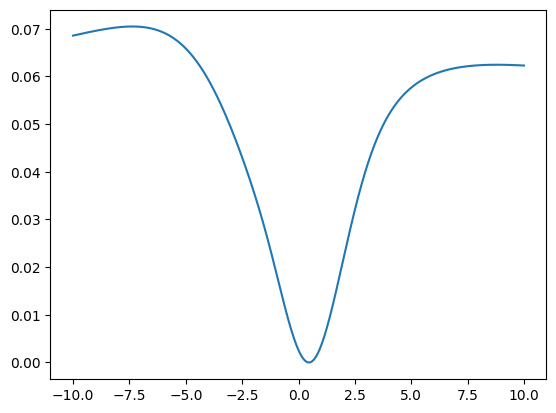

In [113]:
plt.plot(x.detach().numpy(), (psi_y**2).detach().numpy())

In [114]:
def potential_energy(wf, inputs, delta):
    temp = 0.5*(mass*omega**2)*wf(inputs)**2*inputs**2
    return torch.sum(temp)*delta

In [115]:
def kinetic_energy(wf, inputs, delta):
    y = wf(inputs)
    dPsidx = torch.autograd.grad(y, inputs=inputs, 
                                 grad_outputs=torch.ones_like(y))
    #dPsidx = y.backward(torch.Tensor())
    #print(len(dPsidx)) - a tuple of length one?
    return (1.0/(2.0*mass))*torch.sum(dPsidx[0]**2)*delta


In [116]:
def normalization(wf, inputs, delta):
    psi2 = wf(inputs)**2
    return torch.sum(psi2)*delta

In [117]:
def total_energy(wf, inputs, delta):
    norm = normalization(wf, inputs, delta)
    pe = potential_energy(wf, inputs, delta)
    ke = kinetic_energy(wf, inputs, delta)
    #print("norm=",norm,"ke=",ke,"pe=",pe)
    return (pe+ke)/norm

In [118]:
print(psi.norm)
print(normalization(psi,x,delta))

tensor([0.5882])
tensor(1.0000, grad_fn=<MulBackward0>)


In [119]:
total_energy(psi, x, delta)

tensor(21.3205, grad_fn=<DivBackward0>)

In [120]:
psi = WaveFunction()
psi.update_norm(x)
psi_y = psi(x)
optimizer = torch.optim.Adam(psi.parameters(), lr=0.0001)
optimizer.zero_grad()
# cant go up to 10000?
for i in range(3000):
    psi.update_norm(x)
    energy=total_energy(psi,x,delta) # this is the loss!
    energy.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i%300==0:
        print(energy)

tensor(9.8548, grad_fn=<DivBackward0>)
tensor(0.7140, grad_fn=<DivBackward0>)
tensor(0.5130, grad_fn=<DivBackward0>)
tensor(0.5093, grad_fn=<DivBackward0>)
tensor(0.5071, grad_fn=<DivBackward0>)
tensor(0.5055, grad_fn=<DivBackward0>)
tensor(0.5044, grad_fn=<DivBackward0>)
tensor(0.5036, grad_fn=<DivBackward0>)
tensor(0.5031, grad_fn=<DivBackward0>)
tensor(0.5029, grad_fn=<DivBackward0>)


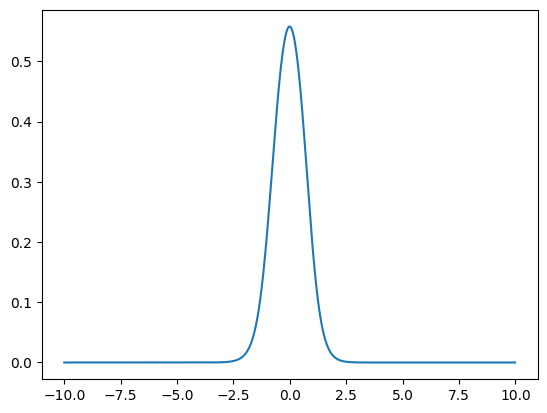

In [121]:
psi.update_norm(x)
psi_y = psi(x)
plt.plot(x.detach().numpy(), (psi_y**2).detach().numpy())